# Initial Data Exploration For Microscopic Image Morphing And Generating Intermediate Images

## Preparation

### Used imports

In [1]:
import openslide # Loading WSI images
import cv2 # Image processing
from scipy.spatial.distance import jensenshannon # Jensen-Shannon Distance
from PIL import Image
from skimage import io, color
from skimage.exposure import rescale_intensity, equalize_hist # ??
from skimage.color import separate_stains, hdx_from_rgb # Ruifrok and Johnston deconvolution
from rembg import remove # Background cleaning
from skimage.metrics import structural_similarity # SSIM

import matplotlib.pyplot as plt
import numpy as np

# Save processed images
import os
import tifffile

### Define notebook static variables

In [2]:
data_dir = '../data/'
wsi_dir = data_dir + 'WSI_scans/'

wsi_scan = ['1M01.mrxs', '1M02.mrxs']

def sample_lod_path(lod: int, wsi_scan: str, num: int, mask: bool = False):
    sample_path = data_dir + f'Samples_LoD_{lod}/{wsi_scan}/{num}.tiff' 
    if mask:
        return sample_path, data_dir + f'Samples_LoD_{lod}/{wsi_scan}/{num}_mask.tiff'
    else:
        return sample_path

### Notebook parameters

In [3]:
scan_lod = 2
used_wsi_scan = wsi_scan[0]
override_saved = False

## Display data
Data for this project consists of histologic WSI images of colon tissue stained with **[haematoxylin](https://en.wikipedia.org/wiki/Haematoxylin)** and **[eosin](https://en.wikipedia.org/wiki/Eosin)**. Each scan contain 3 consecutive tissue`s layers which will be used for morphing the 2 outermost elements to be as simmilar as possible to the middle one  

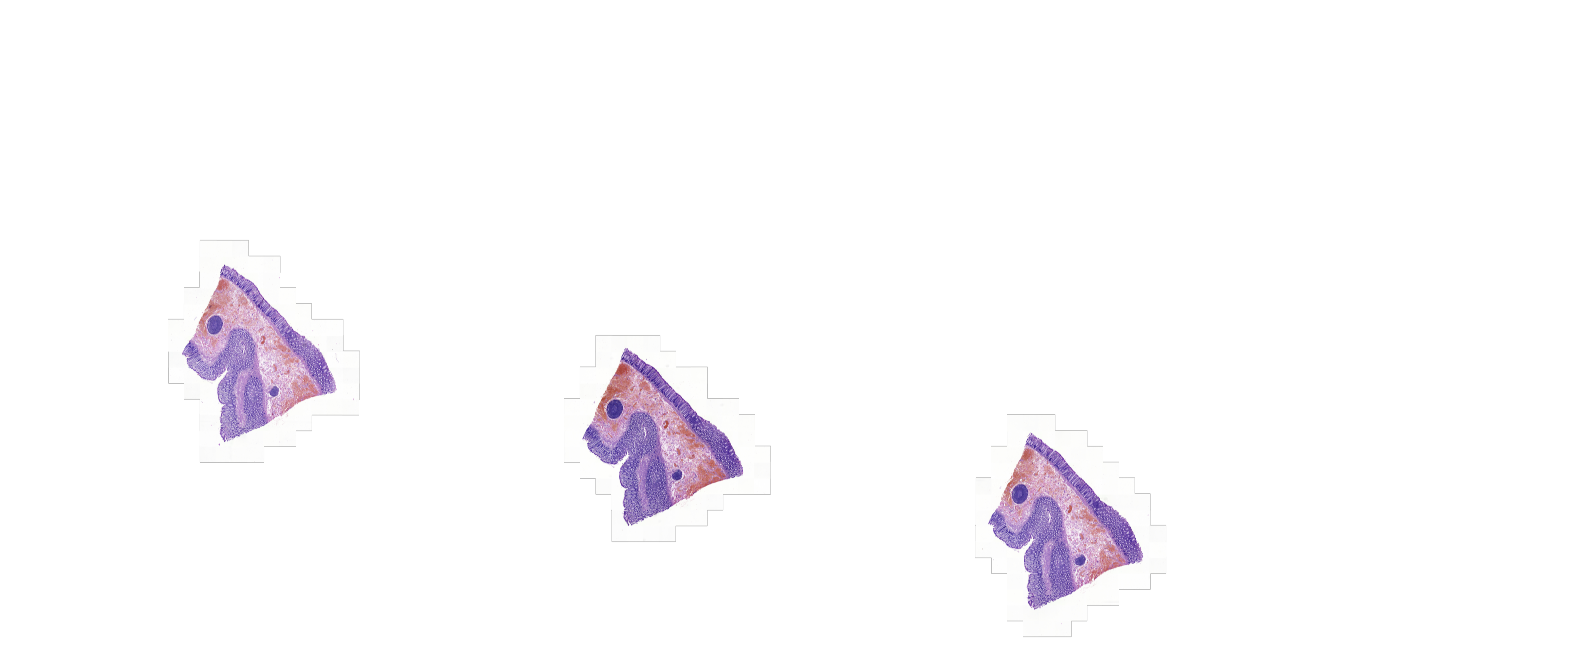

In [4]:
slide = openslide.OpenSlide(wsi_dir + used_wsi_scan)

image = slide.read_region((0, 0), scan_lod, slide.level_dimensions[scan_lod])
image = image.transpose(method=Image.Transpose.ROTATE_90)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(image)
ax.axis('off')
plt.show()

## Object detection
The first challenge in the process is to extract relevant regions of interest (tissue samples) from the image. To achieve this, I will employ the **[Canny edge detection algorithm](https://en.wikipedia.org/wiki/Canny_edge_detector)** on a downscaled version of the whole slide image. This step enables the identification of approximate contours corresponding to the tissue structures. Subsequently, these contours will be analyzed to determine bounding boxes that encapsulate the detected objects, with an additional offset applied to ensure complete coverage of the tissue region.

The resulting bounding box is defined relative to the image dimensions, allowing for flexible scaling to any resolution level. This transformation is achieved using a coordinate translation function, ensuring consistency across different magnification levels.

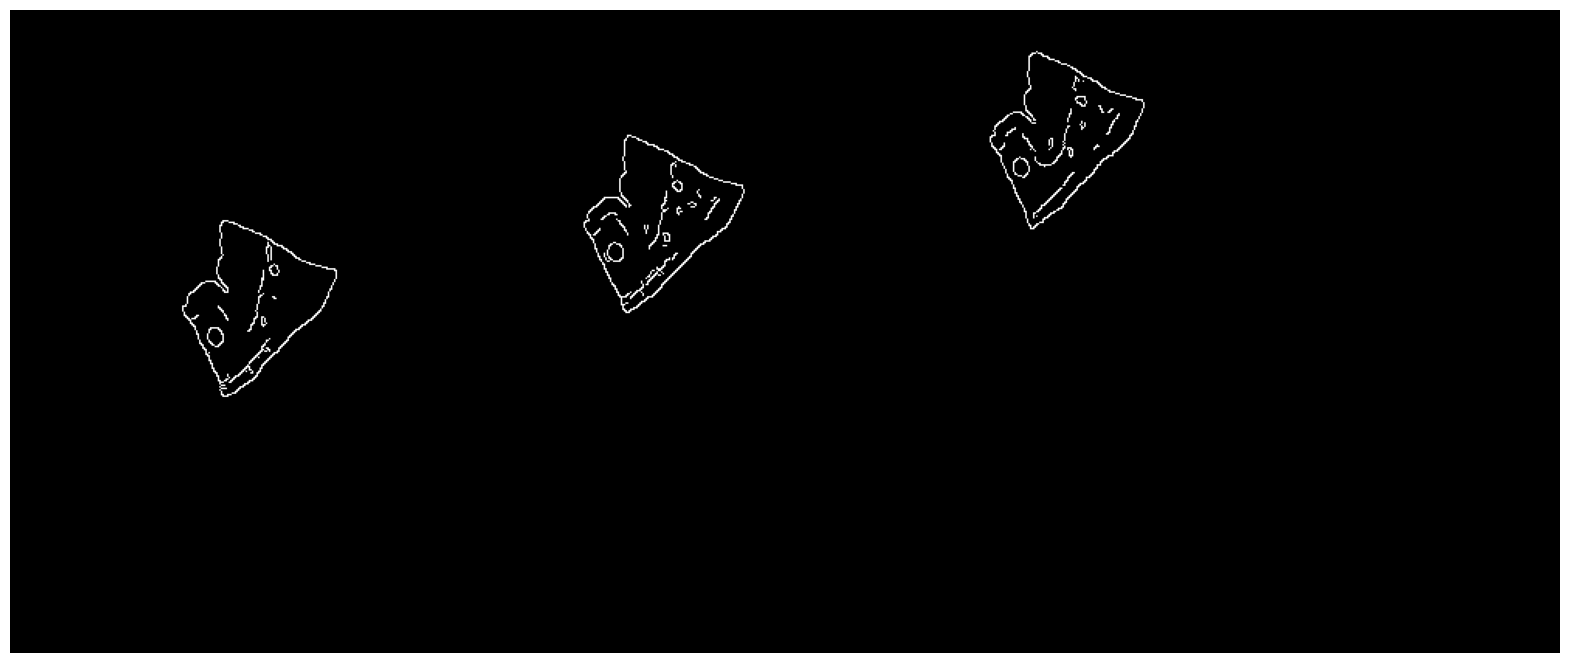

In [5]:
# Get miniature
t_img = slide.get_thumbnail((1000, 1000))
# Convert image to ndarray and gray-scale
t_img = cv2.cvtColor(np.array(t_img), cv2.COLOR_BGR2GRAY)
# Detect edges in image
edges = cv2.Canny(t_img, 150, 250)
# Get contures of our samples
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(edges.T, cmap='gray')
ax.axis('off')
plt.show()

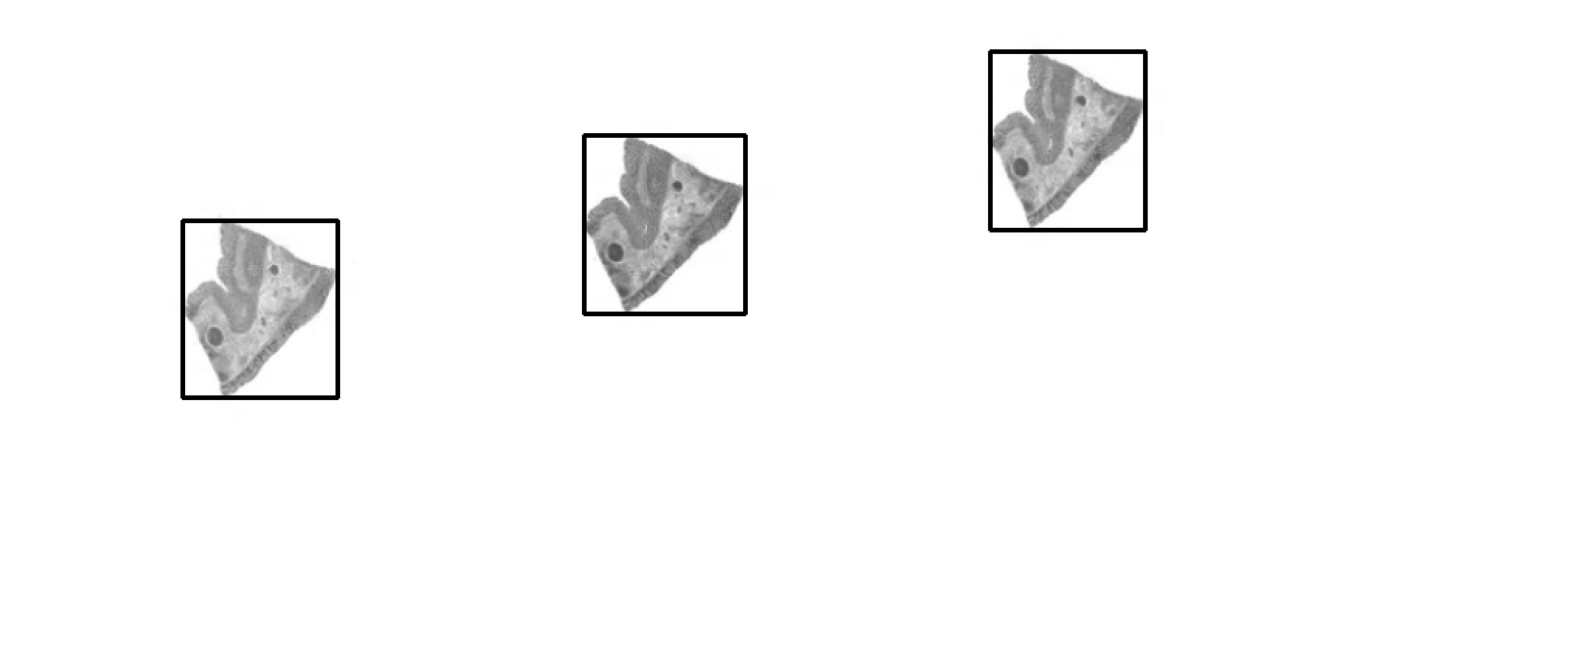

In [6]:
# Get bounding rectangles for detected contours
rects = []
for contour in contours:
    rect = cv2.boundingRect(contour)
    rects.append(rect)

# Check if contures are external
rects.sort(key=lambda x: x[2]*x[3], reverse=True)

def contains(rect_a, rect_b):
    x1, y1, w1, h1 = rect_a
    x2, y2, w2, h2 = rect_b
    return x1 <= x2 and y1 <= y2 and x1 + w1 >= x2 + w2 and y1 + h1 >= y2 + h2

valid_bounds = []

for rect_a in rects:
    is_valid = True
    for rect_b in valid_bounds:
        if contains(rect_b, rect_a):
            is_valid = False
            break
    
    if is_valid:
        # Plot valid external rectangles on the miniature
        valid_bounds.append(rect_a)
        x, y, w, h = rect_a
        cv2.rectangle(t_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(t_img.T, cmap='gray')
ax.axis('off')
plt.show()

### Function definition to get rectangles of tissue regions

In [7]:
def get_tissue_regions(slide: openslide.OpenSlide, box_offset: tuple = (20, 20)):
    img_t = slide.get_thumbnail((1000, 1000))

    # Image pre-processing
    t_img = slide.get_thumbnail((1000, 1000))
    t_img = cv2.cvtColor(np.array(t_img), cv2.COLOR_BGR2GRAY)

    # Contour detection
    edges = cv2.Canny(t_img, 150, 250)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get rectangles
    rects = []
    for contour in contours:
        rect = cv2.boundingRect(contour)
        rects.append(rect)

    # Validate if bound is external
    rects.sort(key=lambda x: x[2]*x[3], reverse=True)
    def contains(rect_a, rect_b):
        x1, y1, w1, h1 = rect_a
        x2, y2, w2, h2 = rect_b
        return x1 <= x2 and y1 <= y2 and x1 + w1 >= x2 + w2 and y1 + h1 >= y2 + h2
    
    valid_bounds = []

    for rect_a in rects:
        is_valid = True
        for rect_b in valid_bounds:
            if contains(rect_b, rect_a):
                is_valid = False
                break
        
        if is_valid:
           valid_bounds.append(rect_a)

    # Offset bounding rectangle 
    result = []
    for bound in valid_bounds:
        x, y, w, h = bound
        result.append((
            (x - box_offset[0]) / t_img.shape[1],
            (y - box_offset[1]) / t_img.shape[0],
            (w + 2*box_offset[0]) / t_img.shape[1],
            (h + 2*box_offset[1]) / t_img.shape[0]
        ))
        
    return result

# Helper function to translate relative rectangle to specific LoD rectangle
def translate_rect(slide: openslide.OpenSlide, level: int, rect: tuple):
    assert level >= 0 and level < slide.level_count
    x, y, w, h = rect
    dim_size = slide.level_dimensions[level]
    dim_pos = slide.level_dimensions[0]

    return int(x * dim_pos[0]), int(y * dim_pos[1]), int(w * dim_size[0]), int(h * dim_size[1])

sample_rects = get_tissue_regions(slide)

### Example use of 'get_tissue_region' and 'translate_rect' functions

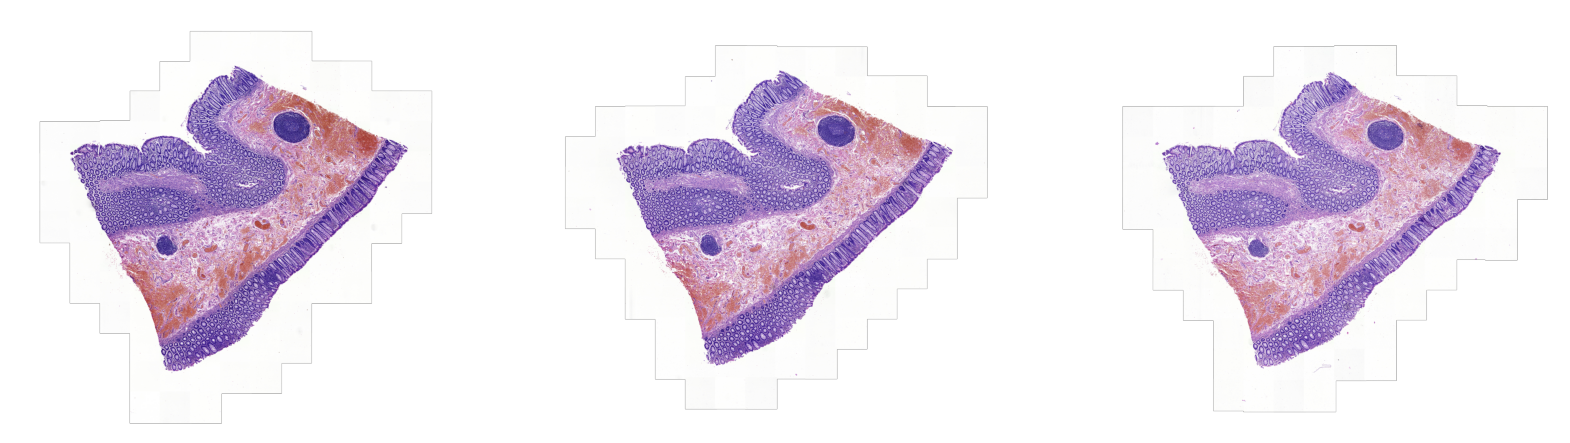

In [8]:
fig, axes = plt.subplots(1, len(sample_rects), figsize=(20, 20))

sample_imgs = []

for i, pos in enumerate(sample_rects):
    x, y, w, h = translate_rect(slide, scan_lod, pos)
    
    image = slide.read_region((x, y), scan_lod, (w, h))
    sample_imgs.append(image)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

### Tissue object size treshold
The size threshold for filtering tissue objects is dynamically determined by identifying the largest drop in area between two consecutive elements in a list of tissue regions sorted by area. This method assumes that a significant decrease in size indicates a transition from relevant tissue to small fragments or noise. The threshold is then set to exclude all objects smaller than this point.

Calculated threshold: None


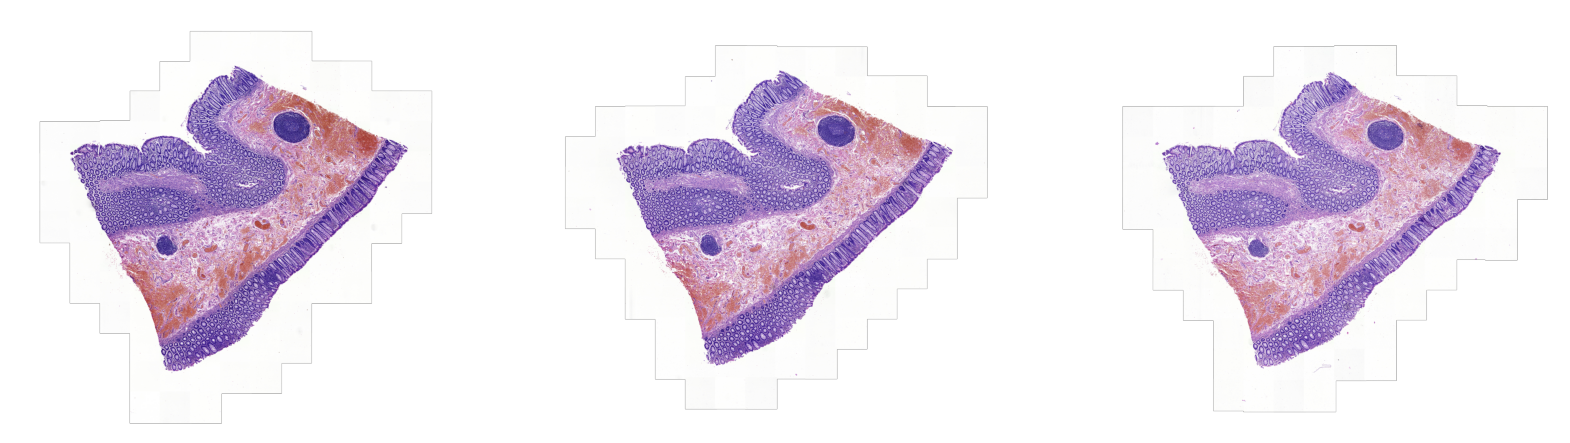

In [9]:
threshold = None
max_prc = 0.2
# Sort tissue rectangles by area
sort_size = sorted(sample_rects, key=lambda x: x[2] * x[3], reverse=True)

# Calculate smallest fraction of size
index = 0
smallest_prc = np.inf
for i in range(1, len(sort_size)):
    a1 = sample_rects[i-1][2] * sample_rects[i-1][3]
    a2 = sample_rects[i][2] * sample_rects[i][3]
    prc = a2/a1

    if prc < smallest_prc:
        smallest_prc = prc
        index = i
        
cleaned_rects = sample_rects
if smallest_prc < max_prc:
    area = sample_rects[index][2] * sample_rects[index][3]
    threshold = area
    cleaned_rects = [rect for rect in sample_rects if rect[2] * rect[3] > threshold]

print(f'Calculated threshold: {threshold}')

sample_imgs = []
fig, axes = plt.subplots(1, len(cleaned_rects), figsize=(20, 20))
for i, pos in enumerate(cleaned_rects):
    x, y, w, h = translate_rect(slide, scan_lod, pos)
    
    image = slide.read_region((x, y), scan_lod, (w, h))
    sample_imgs.append(image)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

## Mask tissue sample from background

### Ruifrok and Johnston deconvolution for background removal

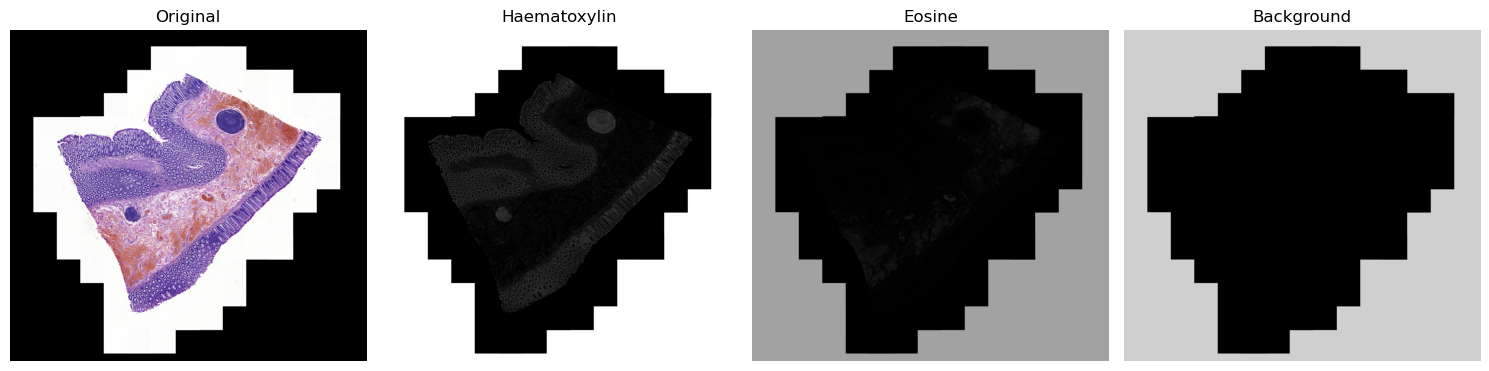

In [10]:
# Example image of one sample
image = np.array(sample_imgs[0])[:,:,:-1]

# Stain matrix for haematoxylin and eosin
stain_matrix = hdx_from_rgb
deconvoluted = separate_stains(image, stain_matrix)
# Scale intensity to equalize histograms

hematoxylin = deconvoluted[:, :, 0]
eosin = deconvoluted[:, :, 1]
background = deconvoluted[:, :, 2]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(hematoxylin, cmap='gray')
axes[1].set_title("Haematoxylin")
axes[2].imshow(eosin, cmap='gray')
axes[2].set_title("Eosine")
axes[3].imshow(background, cmap='gray')
axes[3].set_title("Background")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Create mask from background channel

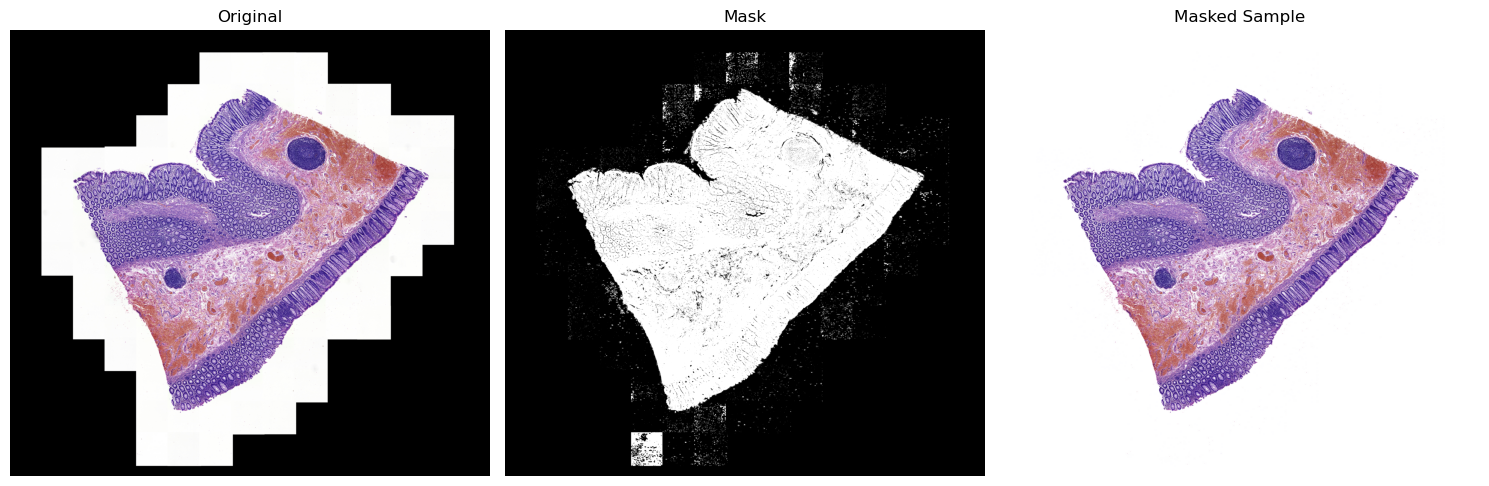

In [11]:
mask = background == 0

# Create image of the mask and apply it
mask_view = (mask * 255).astype(np.uint8)
masked_image = image.copy()
masked_image[~mask] = 255

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(mask_view, cmap='gray')
axes[1].set_title("Mask")
axes[2].imshow(masked_image)
axes[2].set_title("Masked Sample")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

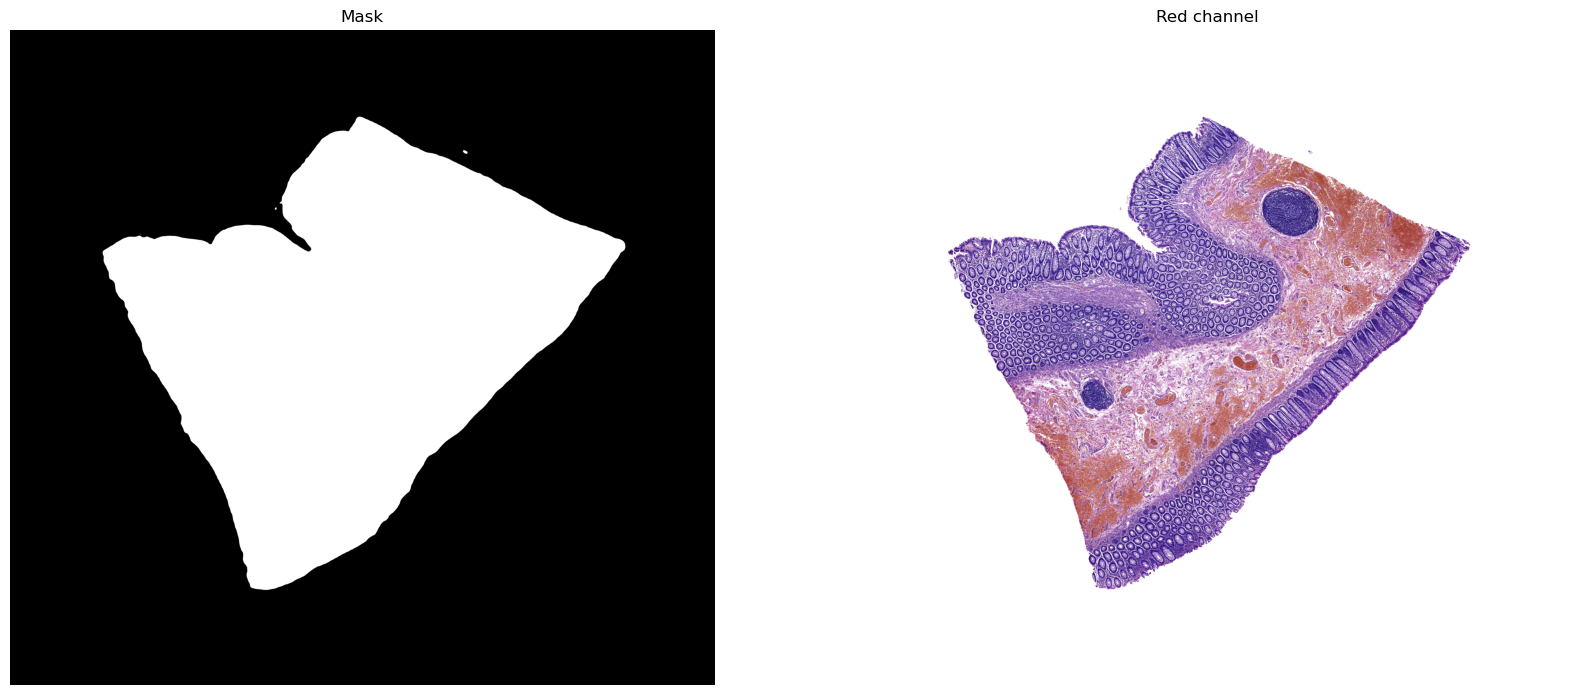

In [12]:
mask = remove(
    masked_image,
    session=None,
    only_mask=True,
    post_process_mask=True,
    alpha_matting=True,
    alpha_matting_foreground_threshold=230,
    alpha_matting_background_threshold=20,
    alpha_matting_erode_size=1,
    alpha_matting_base_size=1000
)

masked_image[~mask.astype(bool)] = 255

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Mask')
axes[1].imshow(masked_image)
axes[1].set_title('Red channel')

for ax in axes:
    ax.axis('off')

plt.show()

### Function definition to get mask of tissue sample

In [13]:
def get_sample_mask(sample: np.ndarray):
    assert(sample.shape[-1] == 3)
    
    # Get background in hdx of sample
    stain_matrix = hdx_from_rgb
    background = separate_stains(sample, stain_matrix)[...,-1]

    # clean background with deconvolution channel
    mask = background == 0
    cleaned = sample.copy()
    cleaned[~mask] = 255

    # clean remains
    mask = remove(
        cleaned,
        session=None,
        only_mask=True,
        post_process_mask=True,
        alpha_matting=True,
        alpha_matting_foreground_threshold=230,
        alpha_matting_background_threshold=20,
        alpha_matting_erode_size=1,
        alpha_matting_base_size=1000
    )
    
    return mask.astype(bool) 

### Masking background from all samples

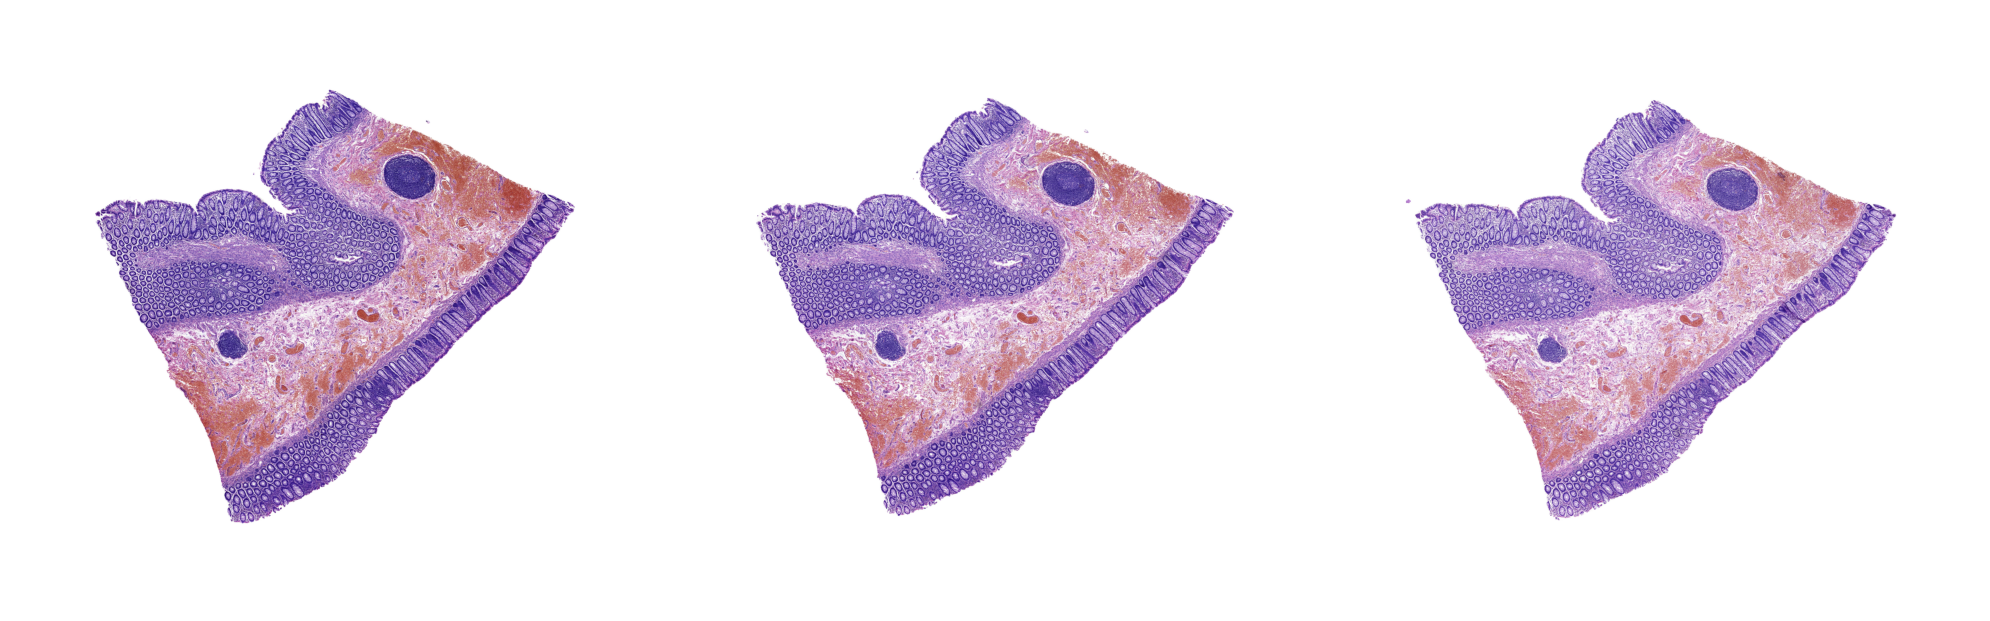

In [14]:
fig, axes = plt.subplots(1, len(sample_imgs), figsize=(20, 20))

sample_masks = []
for i in range(len(sample_imgs)):
    sample_imgs[i] = np.array(sample_imgs[i])[:, :, :3]
    mask = get_sample_mask(sample_imgs[i])
    sample_imgs[i][~mask] = 255
    sample_masks.append(mask)
    
    axes[i].imshow(sample_imgs[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Save processed scan

In [20]:
for i, sample in enumerate(zip(sample_imgs, sample_masks)):
    path = sample_lod_path(scan_lod, used_wsi_scan, i, True)
    exists = os.path.exists(path[0])
    
    if (exists and override_saved) or not exists:
        os.makedirs(os.path.dirname(path[0]), exist_ok=True)
        tifffile.imwrite(path[0], sample[0])
        tifffile.imwrite(path[1], sample[1])